<a href="https://colab.research.google.com/github/alexsalman/CSE247/blob/main/2D_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**Convolutional Neural Network + Long Short Term Memory**
######*I am using a Convolution Neural Network (CNN) + Long Short Term Memory (LSTM) Network to extract general representation while utilizing the Spatial-temporal aspect of the videos.*

In [1]:
# required libraries
import os
import cv2
import random
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Activation, BatchNormalization
from keras.layers import TimeDistributed, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras import regularizers
%matplotlib inline
print(tf.version.VERSION)

2.8.0


In [2]:
# set Numpy, Python, and Tensorflow seeds to get consistent results on every execution
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
# mount dataset from google drive
drive.mount('/content/gdrive/', force_remount=True)
gdrive_path = '/content/gdrive' + '/My Drive/247/'
os.chdir(gdrive_path)
os.getcwd()

Mounted at /content/gdrive/


'/content/gdrive/My Drive/247'

In [4]:
# frame dimention
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
# frame number for each video (depth)
SEQUENCE_LENGTH = 16
# video dir path
DATASET_DIR = gdrive_path + 'Cropped_videos'
# labels of classes
CLASSES_LIST = ['hemostasis', 'inflammatory', 'proliferative', 'maturation']

In [5]:
# image cropping
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

In [6]:
def load_video(path, resize=(128, 128)):
    video_reader = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = video_reader.read()
            if not ret:
                  break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
    finally:
        video_reader.release()
    return np.array(frames) / 255.0

In [7]:
def create_dataset(state):
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name} {state}')
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            # create testing data
            if state == 'test':
                # get the mouse number
                mouse_number = int(video_file_path.split(' ')[2].split('_')[1].split('-')[1])
                # get the mouse side (L or R)
                mouse_side = video_file_path.split(' ')[2].split('_')[1].split('-')[2]
                if mouse_number == 4 and mouse_side == 'L':
                    frames = load_video(video_file_path)
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
            # create validation data
            elif state == 'valid':
                # get the mouse number
                mouse_number = int(video_file_path.split(' ')[2].split('_')[1].split('-')[1])
                # get the mouse side (L or R)
                mouse_side = video_file_path.split(' ')[2].split('_')[1].split('-')[2]
                if mouse_number == 4 and mouse_side == 'R':
                    frames = load_video(video_file_path)
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
            # create training data
            else:
                # get the mouse number
                mouse_number = int(video_file_path.split(' ')[2].split('_')[1].split('-')[1])
                if mouse_number != 4:
                    frames = load_video(video_file_path)
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
    # Converting the list to numpy arrays
    features = np.asarray(features)
    # print(features)
    labels = np.array(labels)
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [8]:
# 6 mice for training, 2 mice for test and validation (one wound on each mice for test one for validation)
features_train, labels_train, video_files_paths_train = create_dataset('train')
features_test, labels_test, video_files_paths_test = create_dataset('test')
features_valid, labels_valid, video_files_paths_valid = create_dataset('valid')

Extracting Data of Class: hemostasis train
Extracting Data of Class: inflammatory train
Extracting Data of Class: proliferative train
Extracting Data of Class: maturation train
Extracting Data of Class: hemostasis test
Extracting Data of Class: inflammatory test
Extracting Data of Class: proliferative test
Extracting Data of Class: maturation test
Extracting Data of Class: hemostasis valid
Extracting Data of Class: inflammatory valid
Extracting Data of Class: proliferative valid
Extracting Data of Class: maturation valid


In [9]:
# labels to catogorical
labels_train = keras.utils.to_categorical(labels_train)
labels_test = keras.utils.to_categorical(labels_test)
labels_valid = keras.utils.to_categorical(labels_valid)

In [10]:
def create_convlstm_model():
    # TimeDistributed is a wrapper to handle input of size five to maintain frames number for LSTM
    # A Conv2D layer requires four dimensions: (batch_size, height, width, channels)
    # TimeDistributed will require an additional dimension: (batch_size, frames, height, width, channels)

    model = Sequential()

    model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu',
                                     kernel_regularizer=regularizers.L2(l2=1e-4)),
                              input_shape=(16, 128, 128, 3)))
    # model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu',
                                     kernel_regularizer=regularizers.L2(l2=1e-4))))
    # model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu',
                                     kernel_regularizer=regularizers.L2(l2=1e-4))))
    # model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
    model.add(Dropout(0.3))

    model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu',
                                     kernel_regularizer=regularizers.L2(l2=1e-4))))
    # model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
    model.add(Dropout(0.3))

    # model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu',
    #                                  kernel_regularizer=regularizers.L2(l2=1e-4))))
    # # model.add(TimeDistributed(BatchNormalization()))
    # model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
    # model.add(Dropout(0.25))

    # model.add(TimeDistributed(Conv2D(40, (3,3), activation='relu',
    #                                  kernel_regularizer=regularizers.L2(l2=1e-4))))
    # # model.add(TimeDistributed(BatchNormalization()))
    # model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
    # model.add(Dropout(0.25))
  
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    model.add(Dropout(0.35))

    model.add(LSTM(4, activation='relu', return_sequences=False))
    model.add(Dropout(0.4))

    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform',
                    kernel_regularizer=regularizers.L2(l2=1e-4)))
    model.add(Dropout(0.4))

    model.add(Dense(8, activation='relu', kernel_initializer='he_uniform',
                    kernel_regularizer=regularizers.L2(l2=1e-4)))
    model.add(Dropout(0.4))

    # model.add(Dense(8, activation='relu', kernel_initializer='he_uniform',
    #                 kernel_regularizer=regularizers.L2(l2=1e-4)))
    # model.add(Dropout(0.5))

    model.add(Dense(4, activation='relu', kernel_initializer='he_uniform',
                    kernel_regularizer=regularizers.L2(l2=1e-4)))
    # model.add(Dropout(0.3))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    model.summary(line_length = 100)
    return model

In [11]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 time_distributed (TimeDistributed)          (None, 16, 126, 126, 8)                 224            
                                                                                                    
 time_distributed_1 (TimeDistributed)        (None, 16, 63, 63, 8)                   0              
                                                                                                    
 dropout (Dropout)                           (None, 16, 63, 63, 8)                   0              
                                                                                                    
 time_distributed_2 (TimeDistributed)        (None, 16, 61, 61, 16)                  1168           
                                                                       

In [12]:
# keras.utils.plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [13]:
# keras.utils.plot_model(convlstm_model,
#                          to_file = 'convlstm_model_structure_plot.png',
#                          show_shapes = True,
#                          show_layer_names = True)

In [14]:
# Create an Instance of Early Stopping Callback

# https://stackoverflow.com/questions/53479007/how-to-setup-adaptive-learning-rate-in-keras
# def adapt_learning_rate(epoch):
#     print(0.0001 * epoch)
#     return 0.0001 * epoch
# my_lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)

early_stopping_callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                        patience = 10,
                                                        mode = 'min',
                                                        restore_best_weights = True)
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy',
                       optimizer= keras.optimizers.Adam(0.0003, decay=1e-4),
                       metrics = ["accuracy"])
# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train,
                                                     y = labels_train,
                                                     epochs = 500,
                                                     batch_size = 32,
                                                     shuffle = True,
                                                     validation_data = (features_valid, labels_valid)),
                                                    #  callbacks = [early_stopping_callback])


Epoch 1/500
51/51 [==============================] - 12s 132ms/step - loss: 1.3468 - accuracy: 0.3769 - val_loss: 1.3675 - val_accuracy: 0.3566
Epoch 2/500
51/51 [==============================] - 5s 107ms/step - loss: 1.3090 - accuracy: 0.3713 - val_loss: 1.3583 - val_accuracy: 0.3566
Epoch 3/500
51/51 [==============================] - 5s 106ms/step - loss: 1.2943 - accuracy: 0.3849 - val_loss: 1.3328 - val_accuracy: 0.3640
Epoch 4/500
51/51 [==============================] - 5s 107ms/step - loss: 1.2455 - accuracy: 0.4047 - val_loss: 1.3082 - val_accuracy: 0.5294
Epoch 5/500
51/51 [==============================] - 5s 106ms/step - loss: 1.2332 - accuracy: 0.4208 - val_loss: 1.2672 - val_accuracy: 0.5515
Epoch 6/500
51/51 [==============================] - 5s 107ms/step - loss: 1.2246 - accuracy: 0.4468 - val_loss: 1.2468 - val_accuracy: 0.5662
Epoch 7/500
51/51 [==============================] - 5s 107ms/step - loss: 1.1894 - accuracy: 0.4598 - val_loss: 1.2069 - val_accuracy: 0.547

In [15]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)
print('\n')
train_loss, train_acc = convlstm_model.evaluate(features_train, labels_train, verbose=0)
test_loss, test_acc = convlstm_model.evaluate(features_test, labels_test, verbose=0)
val_loss, val_acc = convlstm_model.evaluate(features_valid, labels_valid, verbose=0)

print(f'Train accuracy: {train_acc*100:.3f} % || Test accuracy: {test_acc*100:.3f} % || Val accuracy: {val_acc*100:.3f} %')
print('\n')
print(f'Train loss: {train_loss:.3f} || Test loss: {test_loss:.3f} || Val loss: {val_loss:.3f}')

9/9 [==============================] - 0s 43ms/step - loss: 0.7630 - accuracy: 0.7491


Train accuracy: 78.403 % || Test accuracy: 74.908 % || Val accuracy: 80.147 %


Train loss: 0.510 || Test loss: 0.763 || Val loss: 0.889


In [16]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Change dir
gdrive_path = '/content/gdrive' + '/My Drive/247/Saved_models/'
os.chdir(gdrive_path)
# Create a floder for the model files
!mkdir -p convlstm_{current_date_time_string}
# Save your Model.
convlstm_model.save('convlstm_' + str(current_date_time_string) + '/' + model_file_name)
# Save model weights
convlstm_model.save_weights('convlstm_' + str(current_date_time_string) + '/' + 'weights')

In [17]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history[0].history[metric_name_1]
    metric_value_2 = model_training_history[0].history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

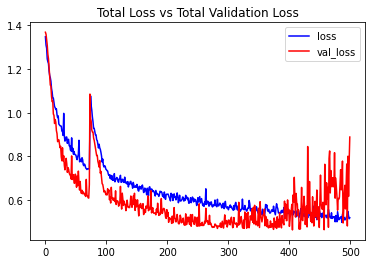

In [18]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

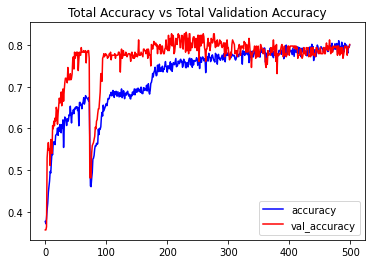

In [19]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 